In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import export_graphviz
import seaborn as sns

warnings.filterwarnings("ignore")
print("All libraries loaded")

All libraries loaded


In [25]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [26]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area 

In [27]:
X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (238, 21), Datos de validación: Datos de prueba ciega: (40, 21)


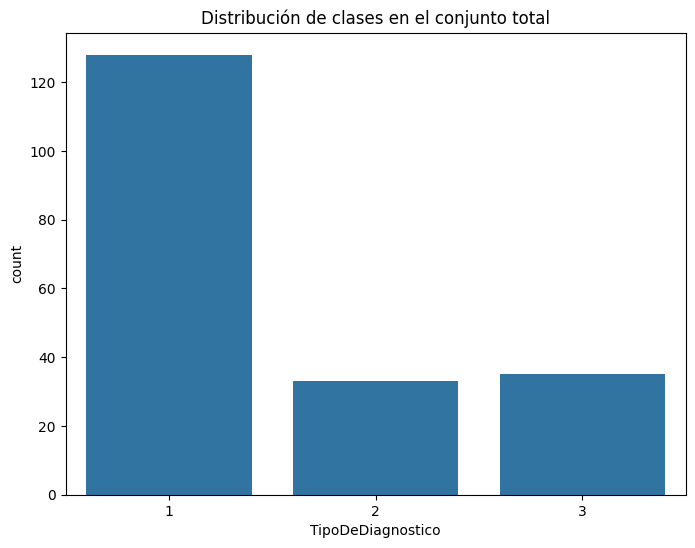

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64


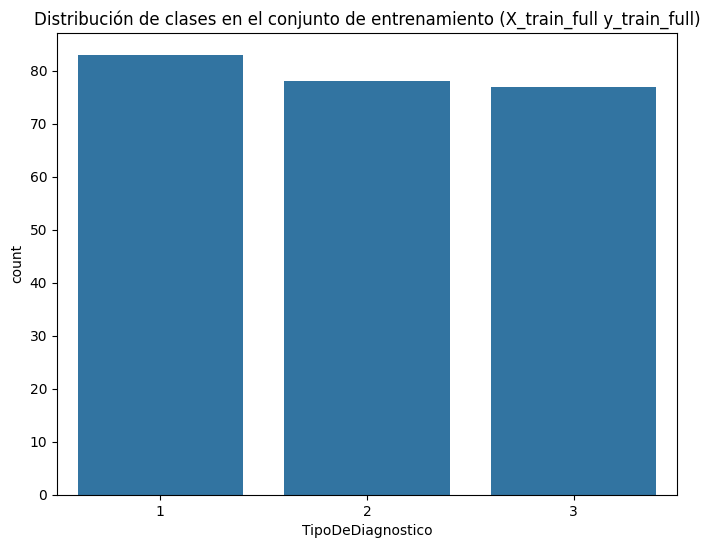

TipoDeDiagnostico
1    83
2    78
3    77
Name: count, dtype: int64


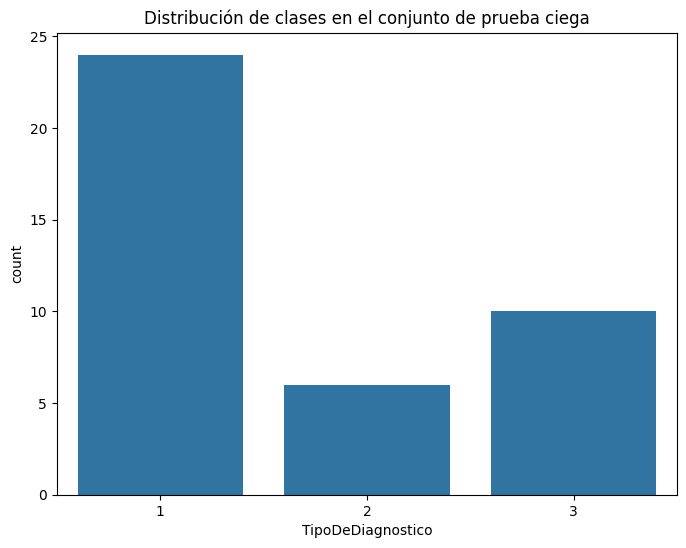

TipoDeDiagnostico
1    24
3    10
2     6
Name: count, dtype: int64


In [28]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_train_full, y_train_full = smote.fit_resample(X_train, y_train)

print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba ciega')
plt.show()
print(y_test_blind.value_counts())

CODIGO DE LGBM

In [29]:
lgb_model = lgb.LGBMClassifier(random_state=42)

param_dist_lgbm = {
    'num_leaves': [31, 50, 100, 150, 200],
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.05, 0.005, 0.001],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}


random_search_lgbm = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgbm,
    n_iter=50,  
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

X_train_full = X_train_full.dropna() 
y_train_full = y_train_full.dropna()

In [30]:
random_search_lgbm.fit(X_train_full, y_train_full)

y_val_pred = random_search_lgbm.best_estimator_.predict(X_train_full)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 238, number of used features: 20
[LightGBM] [Info] Start training from score -1.053430
[LightGBM] [Info] Start training from score -1.115562
[LightGBM] [Info] Start training from score -1.128465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [31]:
mejores_parametros = random_search_lgbm.best_params_
mejor_puntaje = random_search_lgbm.best_score_

print("Mejores parámetros:", mejores_parametros)



Mejores parámetros: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 10, 'num_leaves': 31, 'n_estimators': 100, 'min_child_weight': 1, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [32]:
y_val_pred_lgmb = random_search_lgbm.predict(X_train_full)

print("Evaluación en el conjunto de validación con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_train_full, y_val_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_train_full, y_val_pred_lgmb))

Evaluación en el conjunto de validación con el modelo lgbm:
Accuracy: 0.8319
Precision: 0.8303
Recall: 0.8319
F1 Score: 0.8296

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.81      0.80      0.80        83
           2       0.82      0.74      0.78        78
           3       0.86      0.96      0.91        77

    accuracy                           0.83       238
   macro avg       0.83      0.83      0.83       238
weighted avg       0.83      0.83      0.83       238



In [34]:
y_test_blind_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_blind, y_test_blind_pred_lgbm))

Evaluación en conjunto de prueba ciega con el modelo lgbm:
Accuracy: 0.6500
Precision: 0.7024
Recall: 0.6500
F1 Score: 0.6703

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.85      0.71      0.77        24
           2       0.22      0.33      0.27         6
           3       0.64      0.70      0.67        10

    accuracy                           0.65        40
   macro avg       0.57      0.58      0.57        40
weighted avg       0.70      0.65      0.67        40



In [35]:
y_test_pred_lgmb = random_search_lgbm.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modleo lgbm:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")


Evaluación en conjunto train original con el modleo lgbm:
Accuracy: 0.7372
Precision: 0.7682
Recall: 0.7372
F1 Score: 0.7454


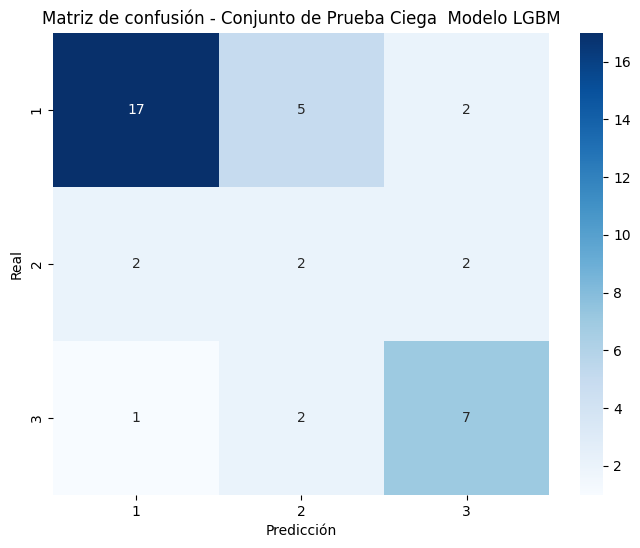

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_blind, y_test_blind_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega  Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

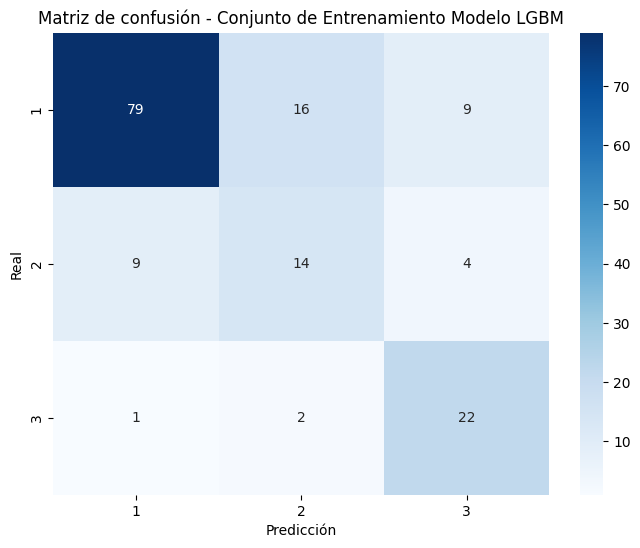

In [37]:
cm = confusion_matrix(y_train, y_test_pred_lgmb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

CATBOOST

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)

param_dist_cat = {
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}
random_search_cat = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_dist_cat, 
    n_iter=20, 
    scoring='f1', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

In [39]:
random_search_cat.fit(X_train_full, y_train_full)

y_pred_lgbm = random_search_cat.best_estimator_.predict(X_train_full)
print("Mejor hiperparámetro encontrado:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor hiperparámetro encontrado: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'border_count': 64}


In [41]:
y_test_blind_pred_cat = random_search_cat.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_blind, y_test_blind_pred_cat))

Evaluación en conjunto de prueba ciega con el modelo catboost:
Accuracy: 0.5500
Precision: 0.6150
Recall: 0.5500
F1 Score: 0.5778

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.75      0.62      0.68        24
           2       0.10      0.17      0.12         6
           3       0.60      0.60      0.60        10

    accuracy                           0.55        40
   macro avg       0.48      0.46      0.47        40
weighted avg       0.61      0.55      0.58        40



In [42]:
y_test_pred_cat = random_search_cat.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_cat):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_cat, average='weighted'):.4f}")

Evaluación en conjunto train original con el modelo catboost:
Accuracy: 0.9038
Precision: 0.9050
Recall: 0.9038
F1 Score: 0.9042


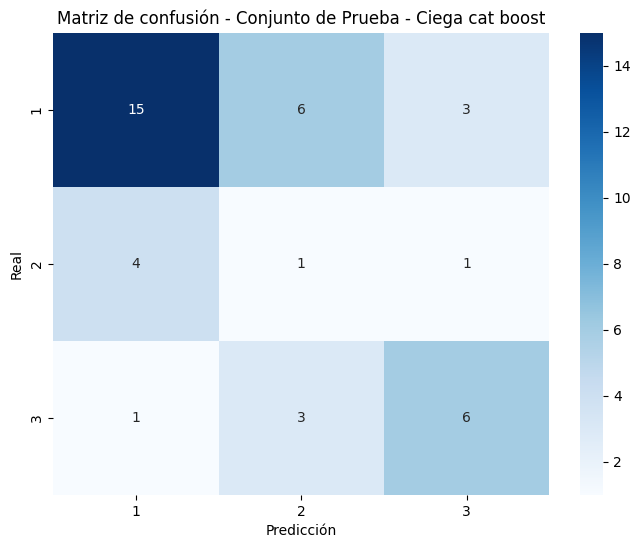

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba - Ciega cat boost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

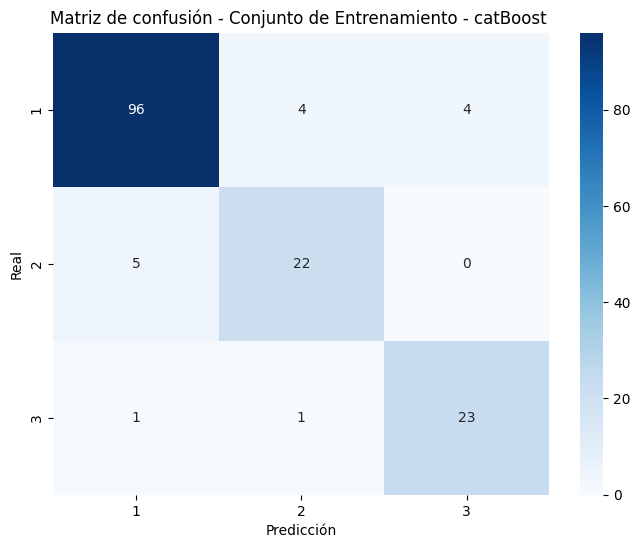

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento - catBoost ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Bagging

In [ ]:
param_grid = {
    'estimator__max_depth': [3, 5, 7, None],
    'estimator__min_samples_split': [2, 5, 10],  
    'estimator__min_samples_leaf': [1, 2, 4],  
    'estimator__max_features': ['sqrt', 'log2'],  
    'n_estimators': [10, 50, 100, 200],  
    'max_samples': [0.5, 0.75, 1.0], 
    'bootstrap': [True, False],  
    'bootstrap_features': [True, False], 
    'oob_score': [True, False], 
    'warm_start': [True, False]  
}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = bagging, 
    param_distributions=param_grid, 
    n_iter=50, 
    cv=cv_strategy, 
    random_state=42, 
    n_jobs=-1,
    scoring='f1',
    verbose=2
)


In [46]:
random_search.fit(X_train_full, y_train_full)
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados: {'warm_start': True, 'oob_score': False, 'n_estimators': 50, 'max_samples': 0.75, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 3, 'bootstrap_features': True, 'bootstrap': False}


In [47]:
y_val_pred = random_search.predict(X_train_full)

print("Evaluación en el conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_train_full, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_train_full, y_val_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train_full, y_val_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train_full, y_val_pred, average='weighted'):.4f}")


Evaluación en el conjunto de validación:
Accuracy: 0.8866
Precision: 0.8893
Recall: 0.8866
F1 Score: 0.8853


In [48]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print("\nReporte de clasificación prueba ciega:\n" + classification_report(y_test_blind, y_test_blind_pred))

Evaluación en conjunto de prueba ciega:
Accuracy: 0.6500
Precision: 0.7283
Recall: 0.6500
F1 Score: 0.6692

Reporte de clasificación prueba ciega:
              precision    recall  f1-score   support

           1       0.88      0.62      0.73        24
           2       0.30      0.50      0.38         6
           3       0.62      0.80      0.70        10

    accuracy                           0.65        40
   macro avg       0.60      0.64      0.60        40
weighted avg       0.73      0.65      0.67        40



In [49]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred, average='weighted'):.4f}")

Evaluación en conjunto train original:
Accuracy: 0.8269
Precision: 0.8312
Recall: 0.8269
F1 Score: 0.8257


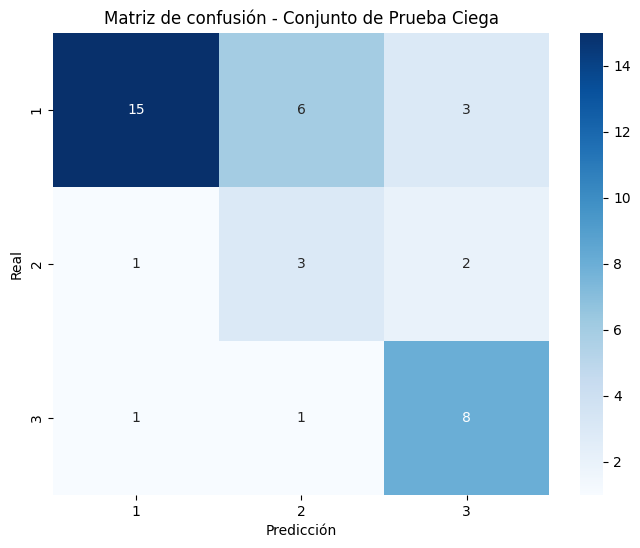

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

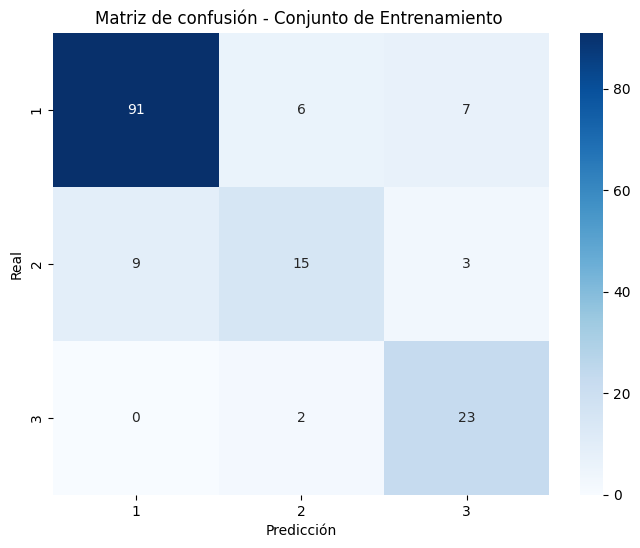

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Variables mas importantes 

Características más importantes en BaggingClassifier:
longitud_relativa_11pm        0.079444
Números con error espacial    0.074236
lowest_point_x                0.070066
Circularidad                  0.061639
Round                         0.060204
lowest_point_y                0.056021
Ángulo entre manecillas       0.055555
puntuacion final              0.054112
Ángulo manecillas 2pm         0.053162
Números algo detectado        0.048021
dtype: float64


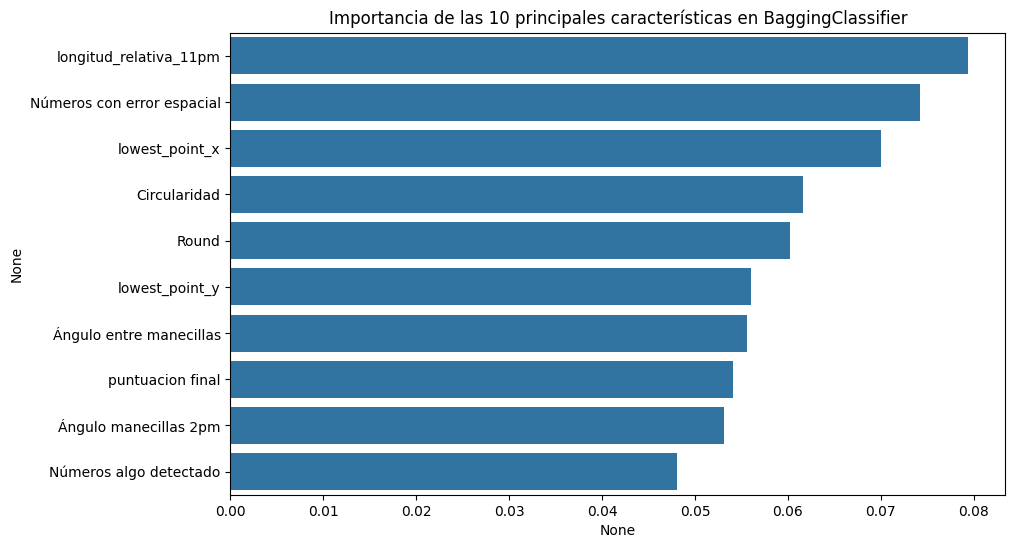

In [52]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()


Características más importantes en CatBoostClassifier:
Area Circulo                  14.469255
Manecilla 11 correcta          7.949881
Números con error espacial     7.178956
Circularidad                   6.668834
longitud_relativa_11pm         6.275267
lowest_point_x                 5.682435
puntuacion final               5.478321
Ángulo manecillas 11am         5.112223
lowest_point_y                 5.031892
Manecillas diferentes          4.657401
dtype: float64


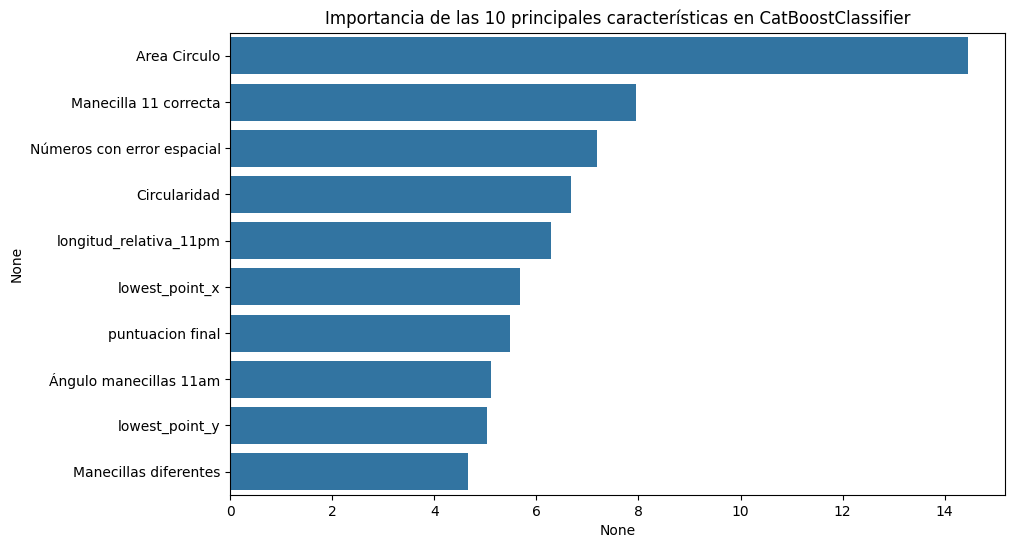

In [53]:
feature_importances = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en CatBoostClassifier:")
print(importancias_catboost.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_catboost.head(10), y=importancias_catboost.index[:10])
plt.title("Importancia de las 10 principales características en CatBoostClassifier")
plt.show()

Características más importantes en LGBMClassifier:
Area Circulo                  98
Circularidad                  93
longitud_relativa_11pm        71
puntuacion final              51
Números con error espacial    45
Ángulo entre manecillas       44
Round                         40
Manecilla 11 correcta         40
Manecillas diferentes         40
Ángulo manecillas 11am        40
dtype: int32


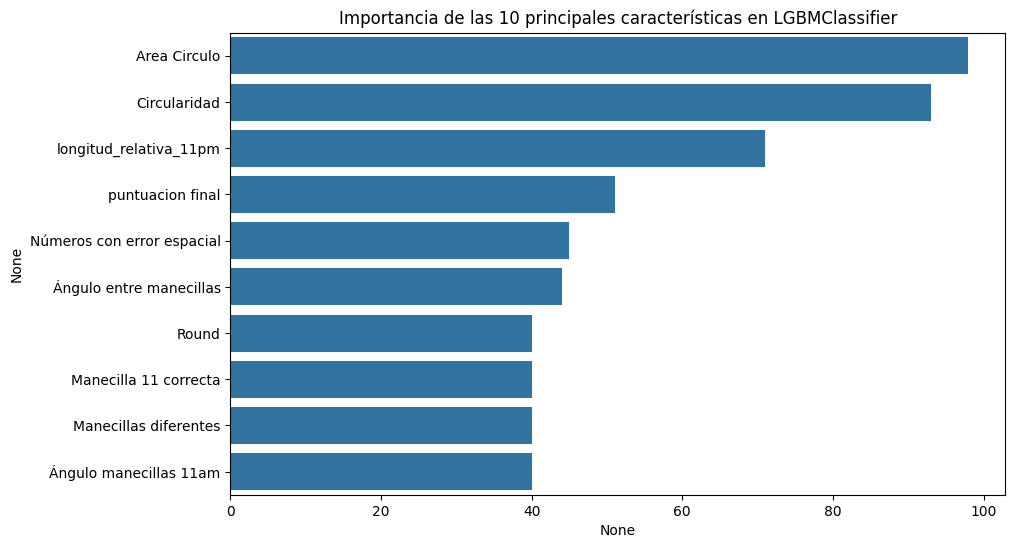

In [54]:
feature_importances = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgb = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en LGBMClassifier:")
print(importancias_lgb.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_lgb.head(10), y=importancias_lgb.index[:10])
plt.title("Importancia de las 10 principales características en LGBMClassifier")
plt.show()

Importancias combinadas:
                           Variable  Importance_CatBoost  Importance_LGBM  \
0                      Area Circulo             1.000000         1.000000   
1                      Circularidad             0.455571         0.948980   
2             Manecilla 11 correcta             0.544981         0.408163   
3              Manecilla 2 correcta             0.155205         0.183673   
4             Manecillas diferentes             0.315183         0.408163   
5            Números algo detectado             0.094662         0.000000   
6        Números con error espacial             0.491174         0.459184   
7  Números detectados correctamente             0.215674         0.102041   
8               Puntuacion contorno             0.000000         0.000000   
9             Puntuacion manecillas             0.208409         0.387755   

   Importance_Bagging  
0            0.139853  
1            0.692840  
2            0.189592  
3            0.000000  
4      

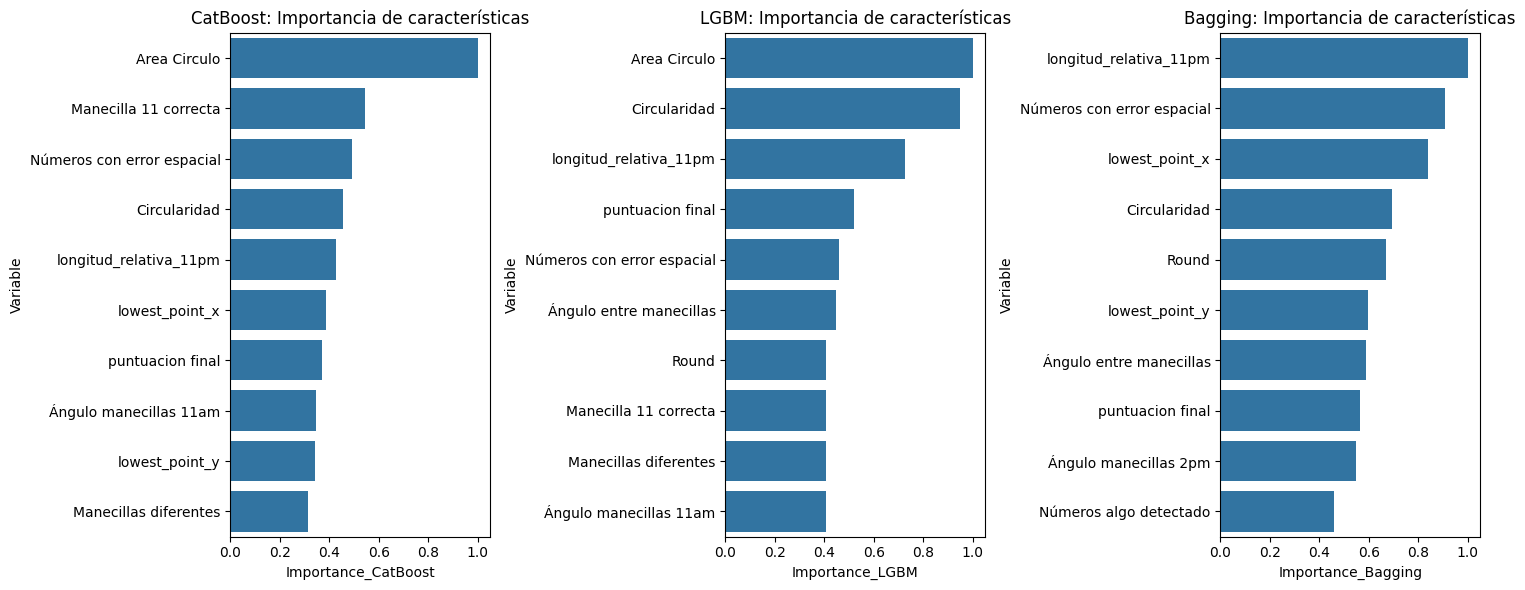

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances_catboost = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances_catboost, index=X_train_full.columns)
importancias_catboost = (importancias_catboost - importancias_catboost.min()) / (importancias_catboost.max() - importancias_catboost.min())
importancias_catboost = importancias_catboost.sort_values(ascending=False)

df_importancias_catboost = pd.DataFrame({
    'Variable': importancias_catboost.index,
    'Importance_CatBoost': importancias_catboost.values
})

feature_importances_lgbm = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgbm = pd.Series(feature_importances_lgbm, index=X_train_full.columns)
importancias_lgbm = (importancias_lgbm - importancias_lgbm.min()) / (importancias_lgbm.max() - importancias_lgbm.min())
importancias_lgbm = importancias_lgbm.sort_values(ascending=False)

df_importancias_lgbm = pd.DataFrame({
    'Variable': importancias_lgbm.index,
    'Importance_LGBM': importancias_lgbm.values
})

feature_importances_bagging = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)
importancias_bagging = pd.Series(feature_importances_bagging, index=X_train_full.columns)
importancias_bagging = (importancias_bagging - importancias_bagging.min()) / (importancias_bagging.max() - importancias_bagging.min())
importancias_bagging = importancias_bagging.sort_values(ascending=False)

df_importancias_bagging = pd.DataFrame({
    'Variable': importancias_bagging.index,
    'Importance_Bagging': importancias_bagging.values
})

df_final = pd.merge(df_importancias_catboost, df_importancias_lgbm, on='Variable', how='outer')
df_final = pd.merge(df_final, df_importancias_bagging, on='Variable', how='outer')

print("Importancias combinadas:")
print(df_final.head(10))

kendall_corr = df_final[['Importance_CatBoost', 'Importance_LGBM', 'Importance_Bagging']].corr(method='kendall')
print("\nCorrelación de Kendall entre las importancias:")
print(kendall_corr)

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x=df_importancias_catboost['Importance_CatBoost'].head(10), 
            y=df_importancias_catboost['Variable'].head(10))
plt.title("CatBoost: Importancia de características")

plt.subplot(1, 3, 2)
sns.barplot(x=df_importancias_lgbm['Importance_LGBM'].head(10), 
            y=df_importancias_lgbm['Variable'].head(10))
plt.title("LGBM: Importancia de características")

plt.subplot(1, 3, 3)
sns.barplot(x=df_importancias_bagging['Importance_Bagging'].head(10), 
            y=df_importancias_bagging['Variable'].head(10))
plt.title("Bagging: Importancia de características")

plt.tight_layout()
plt.show()
